In [150]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
app_data = pd.read_csv("Google-Playstore.csv")
app_data.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [66]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

In [67]:
original_dim = app_data.shape
print(original_dim)

(2312944, 24)


In [68]:
app_data["Price"].value_counts()

0.000000     2268011
0.990000       11851
1.990000        5817
2.990000        3921
1.490000        3823
              ...   
8.205856           1
1.030097           1
13.530000          1
3.550000           1
18.903596          1
Name: Price, Length: 1063, dtype: int64

In [69]:
app_data['Price'].count(), 2268011/2312944

(2312944, 0.980573243450771)

Since over 98% of applications are free, the attribute 'Price' will be inconsequential for predicting Ratings.
Dropping columns like App Id, Currency etc that are not contributing to further analysis.

In [124]:
app_data.drop(['App Id', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Editors Choice', 'Scraped Time','Price'], axis=1, inplace=True)
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Released,Last Updated,Content Rating,Ad Supported,In App Purchases
0,Gakondo,Adventure,0.0,0.0,10+,10.0,15,True,10M,7.1 and up,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False
1,Ampere Battery Info,Tools,4.4,64.0,"5,000+",5000.0,7662,True,2.9M,5.0 and up,"May 21, 2020","May 06, 2021",Everyone,True,False
2,Vibook,Productivity,0.0,0.0,50+,50.0,58,True,3.7M,4.0.3 and up,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,10+,10.0,19,True,1.8M,4.0.3 and up,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False
4,GROW.me,Tools,0.0,0.0,100+,100.0,478,True,6.2M,4.1 and up,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False


In [71]:
print(app_data.isnull().sum())

App Name                2
Category                0
Rating              22883
Rating Count        22883
Installs              107
Minimum Installs      107
Maximum Installs        0
Free                    0
Size                  196
Minimum Android      6530
Released            71053
Last Updated            0
Content Rating          0
Ad Supported            0
In App Purchases        0
dtype: int64


In [72]:
reduced_dim = app_data.shape
print(reduced_dim)

(2312944, 15)


In [125]:
#Dropping rows with null value for particular columns
app_data.dropna(subset=['Rating', 'Rating Count', 'Installs', 'Size', 'Minimum Android','Released'], inplace=True)
reduced_dim = app_data.shape

Preprocessing Content Rating
Mature 17+      => Adult, 
Adults only 18+ => Adult, 
Everyone 10+    => Everyone

In [102]:
app_data['Content Rating'].value_counts()

Everyone    1986881
Teen         189794
Mature        58527
Adults          129
Name: Content Rating, dtype: int64

In [126]:
app_data['Content Rating'] = app_data['Content Rating'].replace('Unrated',"Everyone")

#Cleaning other values just to include Everyone, Teens and Adult 

app_data['Content Rating'] = app_data['Content Rating'].replace('Mature 17+',"Adults")
app_data['Content Rating'] = app_data['Content Rating'].replace('Adults only 18+',"Adults")
app_data['Content Rating'] = app_data['Content Rating'].replace('Everyone 10+',"Everyone")

Preprocessing Content Installs
replaced commmas with no space & dropped + s

In [127]:
app_data.Installs = app_data.Installs.str.replace(',','')
app_data.Installs = app_data.Installs.str.replace('+','')

/var/folders/z6/589dnrx92014vt29m3134f4h0000gn/T/ipykernel_52794/1456762260.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app_data.Installs = app_data.Installs.str.replace('+','')


In [128]:
app_data['Installs'] = pd.to_numeric(app_data['Installs'])
app_data['Installs'] = app_data.apply( lambda row: math.log2(row.Installs+1), axis = 1)

In [78]:
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Released,Last Updated,Content Rating,Ad Supported,In App Purchases
0,Gakondo,Adventure,0.0,0.0,3.459432,10.0,15,True,10M,7.1 and up,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False
1,Ampere Battery Info,Tools,4.4,64.0,12.288001,5000.0,7662,True,2.9M,5.0 and up,"May 21, 2020","May 06, 2021",Everyone,True,False
2,Vibook,Productivity,0.0,0.0,5.672425,50.0,58,True,3.7M,4.0.3 and up,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,3.459432,10.0,19,True,1.8M,4.0.3 and up,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False
4,GROW.me,Tools,0.0,0.0,6.658211,100.0,478,True,6.2M,4.1 and up,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False


Converting app size from string to numeric

In [129]:
def get_app_size( size_str):
    if size_str == 'Varies with device':
        return 0
    metric_unit = size_str[-1]
    val = float(size_str[:-1])
    if metric_unit == 'k' or metric_unit == 'K':
        val = val*1000.0
    elif metric_unit == 'M':
        val = val*1000000.0
    elif metric_unit == 'G':
        val = val*1000000000.0
    else:
        raise Exception(" Value metric not detected {} ".format(size_str))
    return math.log2(val)

In [130]:
app_data.Size = app_data.Size.str.replace(',','')
app_data['Size_Log'] = app_data.apply( lambda row: get_app_size(row.Size), axis = 1)

In [131]:
def processDate(df, columnName):
    # global df
    df_processed =  pd.to_datetime(df[columnName], format='%b %d, %Y')
    df_processed = pd.DataFrame(df_processed)

    df_processed['year'] =  df_processed[columnName].dt.year.astype('Int64')
    df_processed['month'] = df_processed[columnName].dt.month.astype('Int64')

    df['Year '+columnName]=df_processed['year']
    df['Month '+columnName]=df_processed['month']
    df=df.drop([columnName], axis = 1)
    return df

In [132]:
app_data=processDate(app_data, 'Released')
app_data=processDate(app_data, 'Last Updated')

In [83]:
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Content Rating,Ad Supported,In App Purchases,Size_Log,Year Released,Month Released,Year Last Updated,Month Last Updated
0,Gakondo,Adventure,0.0,0.0,3.459432,10.0,15,True,10M,7.1 and up,Everyone,False,False,23.253497,2020,2,2020,2
1,Ampere Battery Info,Tools,4.4,64.0,12.288001,5000.0,7662,True,2.9M,5.0 and up,Everyone,True,False,21.467621,2020,5,2021,5
2,Vibook,Productivity,0.0,0.0,5.672425,50.0,58,True,3.7M,4.0.3 and up,Everyone,False,False,21.819094,2019,8,2019,8
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,3.459432,10.0,19,True,1.8M,4.0.3 and up,Everyone,True,False,20.779565,2018,9,2018,10
4,GROW.me,Tools,0.0,0.0,6.658211,100.0,478,True,6.2M,4.1 and up,Everyone,False,False,22.563837,2020,2,2018,11


<AxesSubplot:>

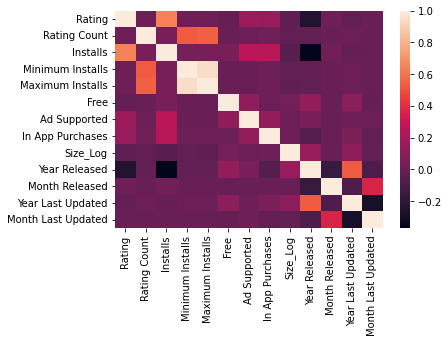

In [84]:
Var_Corr = app_data.corr()
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [85]:
def get_version_value( version):
    if version == 'up':
        return 11
    if version[-1] == 'W':
        version = version[:-1]
    version = version.split('.')
    version.append('0')
    return float("{}.{}".format(version[0], version[1]))

In [86]:
def get_min_version( version):
    if version == 'Varies with device':
        return 0
    elif '-' in version:
        arr = version.split('-')
        return get_version_value(arr[0].strip())
    elif 'and' in version:
        arr = version.split('and')
        return get_version_value(arr[0].strip())
    return get_version_value( version)

In [87]:
def get_max_version( version):
    if version == 'Varies with device':
        return 11
    elif '-' in version:
        arr = version.split('-')
        return get_version_value(arr[1].strip())
    elif 'and' in version:
        arr = version.split('and')
        return get_version_value(arr[1].strip())
    return get_version_value( version)

In [133]:
app_data['Min_Version'] = app_data.apply( lambda row: get_min_version(row['Minimum Android']), axis = 1)
app_data['Max_Version'] = app_data.apply( lambda row: get_max_version(row['Minimum Android']), axis = 1)

In [134]:
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Size,Minimum Android,Content Rating,Ad Supported,In App Purchases,Size_Log,Year Released,Month Released,Year Last Updated,Month Last Updated,Min_Version,Max_Version
0,Gakondo,Adventure,0.0,0.0,3.459432,10.0,15,True,10M,7.1 and up,Everyone,False,False,23.253497,2020,2,2020,2,7.1,11.0
1,Ampere Battery Info,Tools,4.4,64.0,12.288001,5000.0,7662,True,2.9M,5.0 and up,Everyone,True,False,21.467621,2020,5,2021,5,5.0,11.0
2,Vibook,Productivity,0.0,0.0,5.672425,50.0,58,True,3.7M,4.0.3 and up,Everyone,False,False,21.819094,2019,8,2019,8,4.0,11.0
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,3.459432,10.0,19,True,1.8M,4.0.3 and up,Everyone,True,False,20.779565,2018,9,2018,10,4.0,11.0
4,GROW.me,Tools,0.0,0.0,6.658211,100.0,478,True,6.2M,4.1 and up,Everyone,False,False,22.563837,2020,2,2018,11,4.1,11.0


In [135]:
app_data.drop(['Minimum Installs', 'Maximum Installs','Minimum Android'], axis=1, inplace=True)

In [136]:
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Free,Size,Content Rating,Ad Supported,In App Purchases,Size_Log,Year Released,Month Released,Year Last Updated,Month Last Updated,Min_Version,Max_Version
0,Gakondo,Adventure,0.0,0.0,3.459432,True,10M,Everyone,False,False,23.253497,2020,2,2020,2,7.1,11.0
1,Ampere Battery Info,Tools,4.4,64.0,12.288001,True,2.9M,Everyone,True,False,21.467621,2020,5,2021,5,5.0,11.0
2,Vibook,Productivity,0.0,0.0,5.672425,True,3.7M,Everyone,False,False,21.819094,2019,8,2019,8,4.0,11.0
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,3.459432,True,1.8M,Everyone,True,False,20.779565,2018,9,2018,10,4.0,11.0
4,GROW.me,Tools,0.0,0.0,6.658211,True,6.2M,Everyone,False,False,22.563837,2020,2,2018,11,4.1,11.0


In [137]:
category_install = app_data.groupby(['Category'])['Installs'].agg('sum')
category_install

Category
Action                     2.745315e+05
Adventure                  2.272092e+05
Arcade                     4.168088e+05
Art & Design               1.625752e+05
Auto & Vehicles            1.467194e+05
Beauty                     8.803390e+04
Board                      1.070218e+05
Books & Reference          1.100720e+06
Business                   9.522086e+05
Card                       9.292120e+04
Casino                     5.981162e+04
Casual                     4.394518e+05
Comics                     3.173448e+04
Communication              3.999612e+05
Dating                     6.567629e+04
Education                  2.028310e+06
Educational                1.980483e+05
Entertainment              1.326703e+06
Events                     8.335861e+04
Finance                    5.830247e+05
Food & Drink               4.853545e+05
Health & Fitness           6.174226e+05
House & Home               1.036823e+05
Libraries & Demo           4.128525e+04
Lifestyle                  9.70

In [122]:
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Free,Size,Content Rating,Ad Supported,In App Purchases,Size_Log,Year Released,Month Released,Year Last Updated,Month Last Updated,Min_Version,Max_Version
0,Gakondo,0,0.0,0.0,3.459432,0,10M,0,0,0,23.253497,2020,2,2020,2,7.1,11.0
1,Ampere Battery Info,1,4.4,64.0,12.288001,0,2.9M,0,1,0,21.467621,2020,5,2021,5,5.0,11.0
2,Vibook,2,0.0,0.0,5.672425,0,3.7M,0,0,0,21.819094,2019,8,2019,8,4.0,11.0
3,Smart City Trichy Public Service Vehicles 17UC...,3,5.0,5.0,3.459432,0,1.8M,0,1,0,20.779565,2018,9,2018,10,4.0,11.0
4,GROW.me,1,0.0,0.0,6.658211,0,6.2M,0,0,0,22.563837,2020,2,2018,11,4.1,11.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


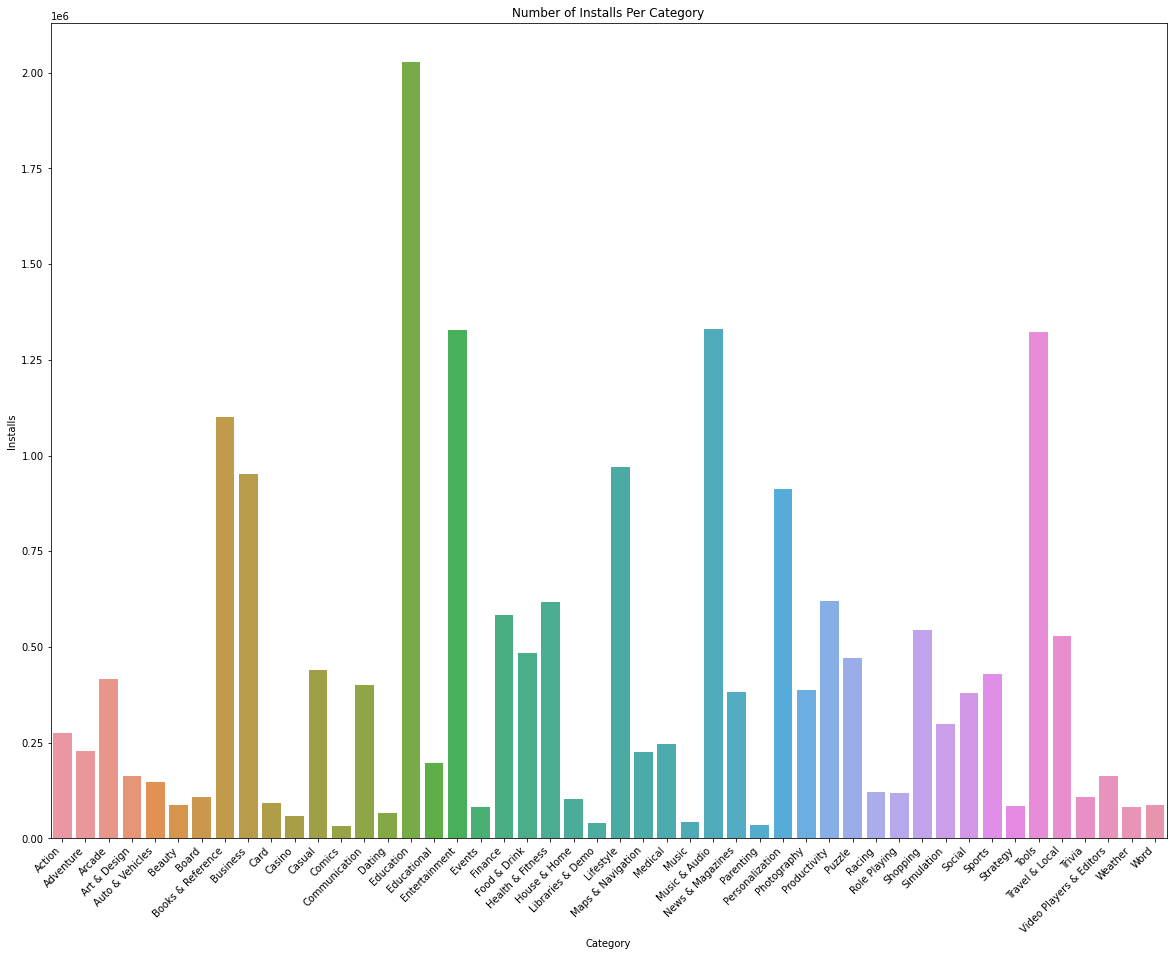

In [138]:
plt.figure(figsize=(20,15))
sns.barplot(category_install.index, category_install.values)
plt.title('Number of Installs Per Category')
plt.xlabel('Category')
plt.ylabel('Installs')
plt.xticks(rotation=45,ha='right');

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


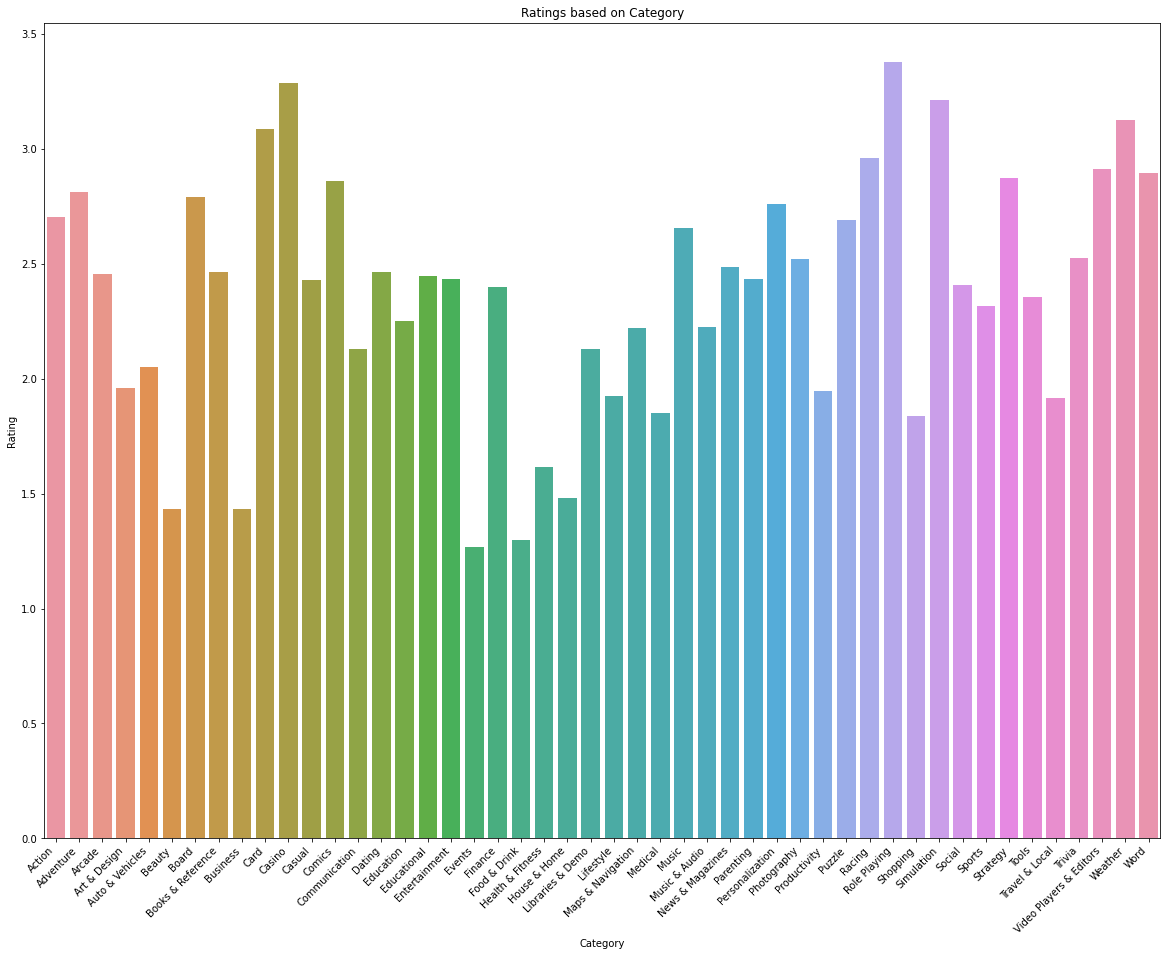

In [139]:
category_rating = app_data.groupby(['Category'])['Rating'].agg('mean')
plt.figure(figsize=(20,15))
sns.barplot(category_rating.index, category_rating.values)
plt.title('Ratings based on Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=45,ha='right');

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Installs')

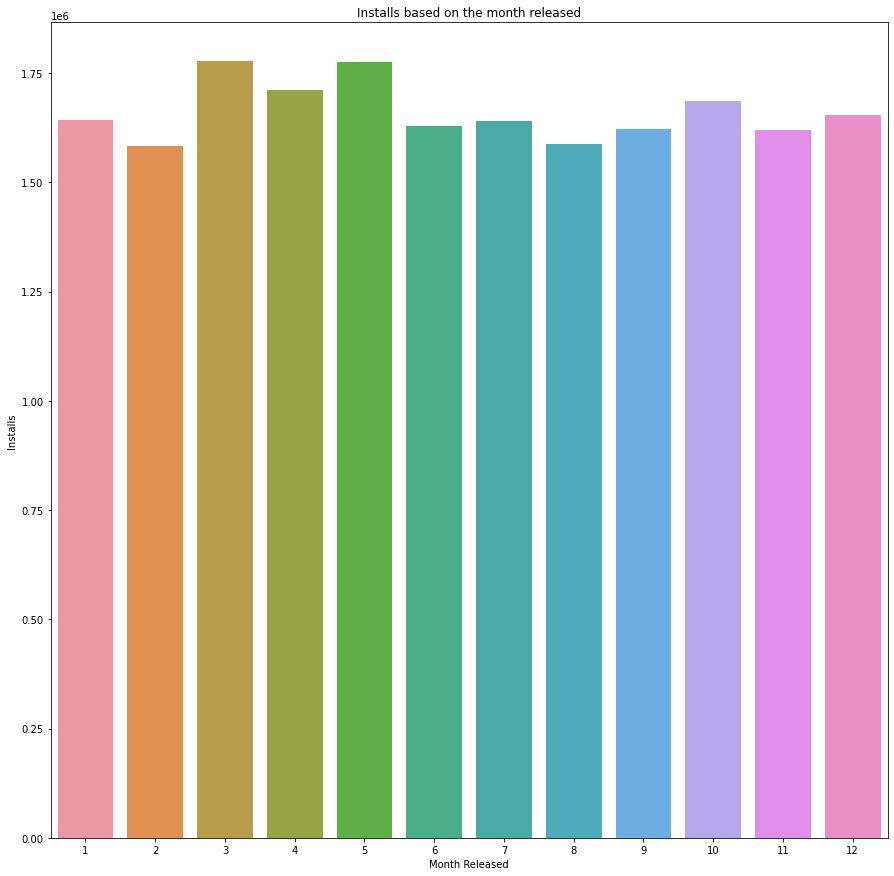

In [140]:
time_install = app_data.groupby(['Month Released'])['Installs'].agg('sum')
plt.figure(figsize=(15,15))
sns.barplot(time_install.index, time_install.values)
plt.title('Installs based on the month released')
plt.xlabel('Month Released')
plt.ylabel('Installs')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Installs')

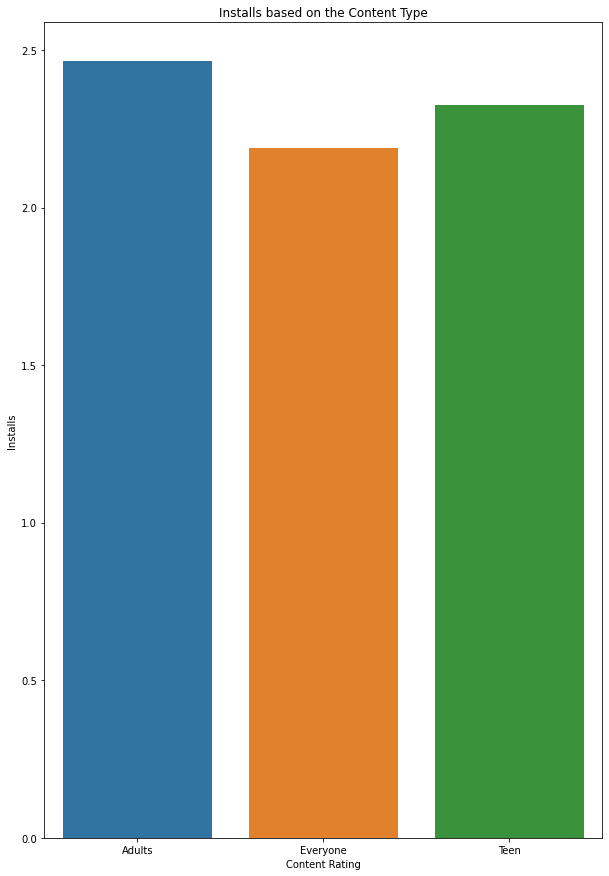

In [141]:
CR_install = app_data.groupby(['Content Rating'])['Rating'].agg('mean')
plt.figure(figsize=(10,15))
sns.barplot(CR_install.index, CR_install.values)
plt.title('Installs based on the Content Type')
plt.xlabel('Content Rating')
plt.ylabel('Installs')

[Text(0.5, 1.0, 'Co-relation between Install count and Rating of an App')]

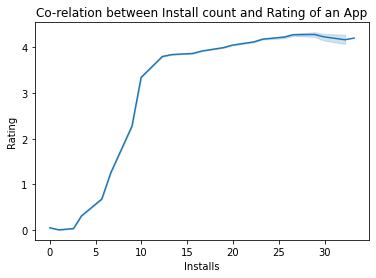

In [35]:
sns.lineplot(data=app_data,x='Installs',y='Rating').set(title='Co-relation between Install count and Rating of an App')

Encode some of the columns as an enumerated type or categorical variable.

In [142]:
app_data['Category'] = pd.factorize(app_data['Category'])[0].astype(int)
app_data['Content Rating'] = pd.factorize(app_data['Content Rating'])[0].astype(int)
app_data['Ad Supported'] = pd.factorize(app_data['Ad Supported'])[0].astype(int)
app_data['In App Purchases'] = pd.factorize(app_data['In App Purchases'])[0].astype(int)
app_data['Free'] = pd.factorize(app_data['Free'])[0].astype(int)
app_data.head()

,App Name,Category,Rating,Rating Count,Installs,Free,Size,Content Rating,Ad Supported,In App Purchases,Size_Log,Year Released,Month Released,Year Last Updated,Month Last Updated,Min_Version,Max_Version
0,Gakondo,0,0.0,0.0,3.459432,0,10M,0,0,0,23.253497,2020,2,2020,2,7.1,11.0
1,Ampere Battery Info,1,4.4,64.0,12.288001,0,2.9M,0,1,0,21.467621,2020,5,2021,5,5.0,11.0
2,Vibook,2,0.0,0.0,5.672425,0,3.7M,0,0,0,21.819094,2019,8,2019,8,4.0,11.0
3,Smart City Trichy Public Service Vehicles 17UC...,3,5.0,5.0,3.459432,0,1.8M,0,1,0,20.779565,2018,9,2018,10,4.0,11.0
4,GROW.me,1,0.0,0.0,6.658211,0,6.2M,0,0,0,22.563837,2020,2,2018,11,4.1,11.0


In [143]:
y = app_data['Rating'].values.round()
print(y[0:10])

[0. 4. 0. 5. 0. 0. 4. 2. 5. 5.]


In [144]:
X = app_data.drop(['App Name', 'Rating', 'Rating Count', 'Size', 'Year Released', 'Month Released', 'Year Last Updated','Month Last Updated'], axis=1)
X.head()

,Category,Installs,Free,Content Rating,Ad Supported,In App Purchases,Size_Log,Min_Version,Max_Version
0,0,3.459432,0,0,0,0,23.253497,7.1,11.0
1,1,12.288001,0,0,1,0,21.467621,5.0,11.0
2,2,5.672425,0,0,0,0,21.819094,4.0,11.0
3,3,3.459432,0,0,1,0,20.779565,4.0,11.0
4,1,6.658211,0,0,0,0,22.563837,4.1,11.0


In [145]:
std_scaler = StandardScaler()
X['Installs'] = std_scaler.fit_transform(X[['Installs']])
X['Size_Log'] = std_scaler.fit_transform(X[['Size_Log']])
X['Min_Version'] = std_scaler.fit_transform(X[['Min_Version']])
X['Max_Version'] = std_scaler.fit_transform(X[['Max_Version']])
X.head()

,Category,Installs,Free,Content Rating,Ad Supported,In App Purchases,Size_Log,Min_Version,Max_Version
0,0,-1.205850,0,0,0,0,0.114331,2.903848,0.013597
1,1,0.745363,0,0,1,0,-0.349857,0.725563,0.013597
2,2,-0.716754,0,0,0,0,-0.258501,-0.311715,0.013597
3,3,-1.205850,0,0,1,0,-0.528698,-0.311715,0.013597
4,1,-0.498884,0,0,0,0,-0.064926,-0.207987,0.013597


In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [147]:
count = {}
for i in y_train:
    if i not in count:
        count[i] = 0
    count[i] = count[i] + 1
print(count)

{0.0: 827573, 3.0: 113993, 5.0: 272328, 4.0: 540987, 2.0: 31049, 1.0: 2334}


In [117]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_pred,y_test)*100
print("Accuracy =",round(rf_acc,2),"%")

Accuracy = 65.27 %


In [118]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit( X_train, y_train)
lr_pred = clf.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)*100
print("Accuracy =",round(lr_acc,2),"%")

Accuracy = 69.08 %


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [151]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_acc = accuracy_score(y_test,gb_pred)*100
print("Accuracy =",round(gb_acc,2),"%")

Accuracy = 69.31 %


In [148]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
mlp_clf.fit( X_train, y_train)
mlp_pred = mlp_clf.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_pred)*100
print("Accuracy =",round(mlp_acc,2),"%")

Accuracy = 69.24 %


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

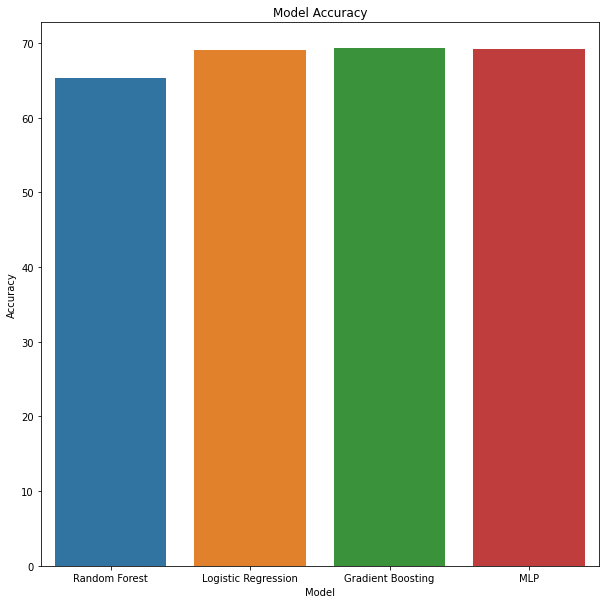

In [164]:
acc = pd.Series(index=['Random Forest','Logistic Regression','Gradient Boosting','MLP'], data=[rf_acc,lr_acc,gb_acc,mlp_acc])
plt.figure(figsize=(10,10))
s = sns.barplot(acc.index,acc.values)
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')